# REINFORCEMENT LEARNING


Reinforcement learning problems are usually modeled as _Markov Decision Processes_. A Markov Decision Process is a quadruple $(S, A, T, R)$, such that:
 * $S$ is a set called _set of states_,
 * $A$ is a set called _set of actions_,
 * $T : S \times A \times S \to [0, 1]$ is a function called _transition probability function_, and
 * $R : S \times A \to \mathbb{R}$ is a function called _reward function_.

Moreover, the function $T$ satisfies the condition
$$
    \sum_{t \in S} T(s, a, t) = 1
    \quad \text{for all } \ s \in S \text{ and } a \in A.
$$

Markov Decision Processes are used to model not only reinforcement learning problems but a variety of decision problems. Given one of these problems, one usually wishes to determine what is the best action to choose in each state in order to maximize one's long-term reward. A function $\pi : S \to A$ that assigns an action to each state is called a _policy_, and in this notebook, we will show methods to construct such policies.


We begin by loading two Python libraries that will be used throughout this notebook:


In [ ]:
import numpy as np
import random


# 1. A simple Markov Decision Process

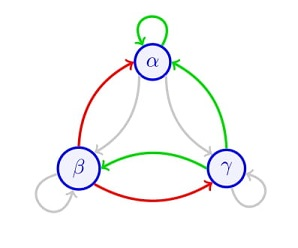


In this section, we will consider a very simple Markov Decision Process in which one has a set of three states, $S = \{ \alpha, \beta, \gamma \}$, and for each state, one can choose between two actions, $A = \{\text{stay}, \text{move}\}$.


In [ ]:
# Create a set with three states: alpha, beta and gamma.
states = range(3)

# Create a set with two actions: stay and move.
actions = range(2)


Consider also that, if an agent is in a certain state and decides to 'stay', then their state does not change.  However, if an agent is in a certain state and decides to 'move', then they could end up in one of the other two states.  That is, even though the decision to 'stay' is deterministic, the decision to 'move' is stochastic.  For example, let the function $T(s, a, s')$ that describes the probability of being in state $s$, taking action $a$, and ending up in state $s'$ be the following:
\begin{gather*}
    T(\alpha, \text{stay}, \alpha) = 100\%, \quad T(\alpha, \text{stay}, \beta) = 0\%, \quad T(\alpha, \text{stay}, \gamma) = 0\%, \\
    T(\beta, \text{stay}, \alpha) = 0\%, \quad T(\beta, \text{stay}, \beta) = 100\%, \quad T(\beta, \text{stay}, \gamma) = 0\%, \\
    T(\gamma, \text{stay}, \alpha) = 0\%, \quad T(\gamma, \text{stay}, \beta) = 0\%, \quad T(\gamma, \text{stay}, \gamma) = 100\%, \\
    T(\alpha, \text{move}, \alpha) = 0\%, \quad T(\alpha, \text{move}, \beta) = 50\%, \quad T(\alpha, \text{move}, \gamma) = 50\%, \\
    T(\beta, \text{move}, \alpha) = 25\%, \quad T(\beta, \text{move}, \beta) = 0\%, \quad T(\beta, \text{move}, \gamma) = 75\%, \\
    T(\gamma, \text{move}, \alpha) = 33\%, \quad T(\gamma, \text{move}, \beta) = 67\%, \quad T(\gamma, \text{move}, \gamma) = 0\%.
\end{gather*}


In [ ]:
# Initialize a matrix full of zeros
T = np.zeros((3, 2, 3))

# Set the nonzero transition probabilities
T[0, 0, 0] = 1.0     # T[alpha, stay, alpha]
T[0, 1, 1] = 0.5     # T[alpha, move, beta]
T[0, 1, 2] = 0.5     # T[alpha, move, gamma]
T[1, 1, 0] = 0.25    # T[beta, move, alpha]
T[1, 0, 1] = 1.0     # T[beta, stay, beta]
T[1, 1, 2] = 0.75    # T[beta, move, gamma]
T[2, 1, 0] = 0.33    # T[gamma, move, alpha]
T[2, 1, 1] = 0.67    # T[gamma, move, beta]
T[2, 0, 2] = 1.0     # T[gamma, stay, gamma]


Finally, suppose that the reward obtained by staying in state $\alpha$ is $10$, that the reward obtained by moving away from $\beta$ is $-40$, that the reward obtained from moving away from $\gamma$ is $20$, and that all other rewards are $0$.  That is, the function $R : S \times A \to \mathbb{R}$ is given by
$$
    R(s, a) =
    \begin{cases}
        \ \ \ 10, & \text{if } s = \alpha \text{ and } a = \text{stay}, \\
        -40, & \text{if } s = \beta \text{ and } a = \text{move}, \\
        \ \ \ 20, & \text{if } s = \gamma \text{ and } a = \text{move}, \\
        \ \ \ \ \ 0, & \text{otherwise}.
    \end{cases}
$$


In [ ]:
# Initialize a matrix full of zeros
R = np.zeros((3, 2))

# Set the nonzero rewards
R[0, 0] = 10     # R[alpha, stay]
R[1, 1] = -40    # R[beta, move]
R[2, 1] = 20     # R[gamma, move]


The following algorithm computes the expected reward $Q(s, a)$ that an agent obtains by taking action $a$ in state $s$.  The value of $Q$ is iteratively given by _Bellman Optimality Equation_,
$$
    Q(s, a) = \sum_{t \in S} T(s, a, t) \left( R(s, a) + d \cdot \max_{b \in A} \{Q(s, b)\} \right),
$$
for each state $s \in S$ and action $a \in A$, where $d \in [0, 1]$ is  a parameter (called _discount rate_) that fixes the rate at which one believes the previous iteration should be devalued.  Intuitively, this equation sets $Q(s, a)$ as a weighted sum (with weights $\{T(s, a, t)\}_{t \in S}$) of the immediate reward $R(s, a)$ and the neighboring expected rewards $\{Q(s, b)\}_{b \in A}$.


In [ ]:
# Initialize the Q-matrix with zeros
Q = np.zeros((3, 2))

# For a number of iterations, update the Q-matrix using the Q-value iteration
# algorithm. Before starting this process, choose the parameters: number of
# iterations and discount rate (how much one devalues previous information).
# Remark: different discount rates may give different results.
n_iterations = 50
discount_rate = 0.9

for _ in range(n_iterations):
    for s in states:
        for a in actions:
            Q[s, a] = np.sum([ T[s, a, t] * (R[s, a] + discount_rate*np.max(Q[t]))  for t in states ])


Using the function $Q$ obtained above, one can construct a policy $\pi : S \to A$ by choosing the action that is expected to return the highest reward for each state:
$$
    \pi(s) = \text{argmax } Q(s, -),
    \quad \text{ for all } s \in S,
$$
where $Q(s, -) : A \to \mathbb{R}$ is the function given by $Q(s, -)(a) = Q(s, a)$.  Notice that, if an agent follows this policy in every state, then they should obtain the highest total reward in the long-term.


In [ ]:
policy = {}

for s in states:
    policy[s] = np.argmax(Q[s])


# 2. A more envolved Markov Decision Process

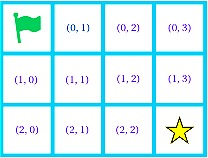


Notice that, in the Markov Decision Process presented in the previous section, the transition probabilities and rewards were all given _a priori_.  In this section, we will consider a Markov Decision Process for which the transition probabilities and rewards are not given _a priori_.  Namely, consider a $3 \times 4$ grid, where each cell represents a state, $S = \{ (i, j) \mid i \in \{0, 1, 2\} \ \text{ and } \ j \in \{0, 1, 2, 3\}\}$, and, in each state, one can take four possible actions, $A = \{\text{left}, \text{up}, \text{right}, \text{down}\}$.  In this case, one's goal is to start in state $(0, 0)$ and reach the state $(2, 3)$.

Since transition probabilities and rewards were not given, we will assume that each action is deterministic, choose rewards for each state-action pair, and let the agent explore the environment.


In [ ]:
ACTIONS = {"left", "up", "right", "down"}

HEIGHT = 3
WIDTH = 4
states = {(i, j)  for i in range(HEIGHT) for j in range(WIDTH)}

INITIAL_STATE = (0, 0)
GOAL = (HEIGHT-1, WIDTH-1)


Next, we construct a loop that makes the agent explore the environment.  That is, starting from the initial state $(0, 0)$, we will choose a random action from the set of actions and take this action, until we reach the fixed goal or a certain maximum number of steps (`MAX_STEPS`). Notice that, while the agent explores the environment, it will collect rewards for its actions: $-1$ for each state that is not the goal, and $5$ for the goal.


In [ ]:
MAX_STEPS = 100

x, y = INITIAL_STATE
n_steps = 0

# Initialize a list to collect the information regarding the exploration
exploration = []

while ((x, y) != GOAL) and (n_steps < MAX_STEPS):
    # Update the number of steps
    n_steps += 1

    # Choose a random action from the set of actions
    action = random.choice(tuple(ACTIONS))

    # Depending on the chosen action, change the current state (x, y). Notice
    # that one should interpret (x, y) as rows and columns of a matrix, not as
    # the cartesian coordinates of a lattice in R².
    if (action == "left") and ((x, y-1) in states):
        y -= 1
    elif (action == "right") and ((x, y+1) in states):
        y += 1
    elif (action == "up") and ((x-1, y) in states):
        x -= 1
    elif (action == "down") and ((x+1, y) in states):
        x += 1
    #else: there is no need to change (x, y)

    # Get a reward that depends on the outcome of the action
    if (x, y) == GOAL:
        reward = 5
    else: # that is, if (x, y) != goal:
        reward = -1

    # Collect and print the information regarding this step
    exploration.append({'state': (x, y), 'reward': reward})
    print(f"Step {n_steps}: (x, y) = {(x, y)} and reward = {reward}")


Now that the agent has explored the environment, it can assign a _value_ to each visited state.  This value is supposed to encode the potential of achieving the goal once the agent is in a certain state.  More precisely, for each visited state $s$, one assigns the number $V(s) \in \mathbb{R}$, which is defined to be a weighted sum of the rewards of the states that were visited after $s$ in the exploration process.  These weighted sums are known as _discounted returns_ or _cumulative rewards_, and the resulting function $V: S \to \mathbb{R}$ is known as the _value function_.


In [ ]:
# Initialize a matrix that will store the values of the value function, that
# is, V((i, j)) = value_matrix[i, j]
value_matrix = np.zeros((HEIGHT, WIDTH))

# Choose the weight of the cumulative future reward in the value of a state
DISCOUNT_RATE = 0.5

# Initialize a number and a list that will record the cumulative (future)
# rewards, starting from the end of the exploration list
cumulative_reward = 0.0
cumulative_rewards = {s: []  for s in states}

for i, step in enumerate(exploration[::-1]):
    x, y = step['state']
    reward = step['reward']

    cumulative_reward = reward + DISCOUNT_RATE * cumulative_reward
    cumulative_rewards[(x, y)].append(cumulative_reward)

    value_matrix[x, y] = sum(cumulative_rewards[(x, y)]) / len(cumulative_rewards[(x, y)])


value_matrix


As in every Markov Decision Process, the main goal is to construct a policy $
\pi: S \to A$.  In this case, we will use the value function constructed above. Namely, for each state $s \in S$, the action $\pi(s)$ will be defined to be the one for which the resulting state has the maximal value.


In [ ]:
# Initialize a dictionary that will record the policy
policy = {}

# For each state in the environment
for i, j in states:

    # Gather the values of its neighboring states
    neighboring_values = {}
    for action in ACTIONS:
        if (action == "left") and ((i, j-1) in states):
            neighbor = (i, j-1)
        elif (action == "right") and ((i, j+1) in states):
            neighbor = (i, j+1)
        elif (action == "up") and ((i-1, j) in states):
            neighbor = (i-1, j)
        elif (action == "down") and ((i+1, j) in states):
            neighbor = (i+1, j)
        else:
            neighbor = (i, j)

        neighboring_values[action] = value_matrix[neighbor]

    # Find the action that has the maximum resulting value and set it as
    # the state's policy
    best_action = max(neighboring_values, key=neighboring_values.get)
    policy[(i, j)] = best_action


policy


Notice that, by runing the above cells, there resulting policy does not reflect our intuition.  In fact, in order for this method to be effective, that is, in order for the value function to converge to a good estimate of the expected value of each state, one must iterate it several times. In the following cell, we will implement this iteration and summarize the whole method in a function.


In [ ]:
def main (height, width, n_explorations=100, discount_rate=0.5, epsilon=0.5):
    """
    :param height (int): height of the environment.
    :param width (int): width of the environment.
    :param n_explorations (int): number of times that the agent explores the
        environment and the value function/matrix is updated.
    :param discount_rate (float): percentage of the future values that
        contribute to the weighted cumulative reward (discounted return) of
        a visited state.
    :param epsilon (float): percentage of the steps in the exploration fase
        that are completely random.

    :return policy (dict): the best action to be taken for each state.
    """
    # Setup the environment
    ACTIONS = {"left", "up", "right", "down"}
    states = {(i, j)  for i in range(height) for j in range(width)}
    goal = (height-1, width-1)
    INITIAL_STATE = (0, 0)

    # Initialize the state-value matrix, the policy dictionary (randomly), and
    # the cumulative rewards dictionary
    value_matrix = np.zeros((height, width))
    policy = {s: random.choice(tuple(ACTIONS))  for s in states}
    cumulative_rewards = {s: []  for s in states}

    # Fix the parameter for the maximum number of steps in a random walk
    MAX_STEPS = 100

    for _ in range(n_explorations):
        # Reset the state and the steps counter
        (x, y) = INITIAL_STATE
        n_steps = 0

        # Initialize a list to collect the info regarding the exploration
        exploration = []

        # Explore the environment somewhat randomly
        while ((x, y) != goal) and (n_steps < MAX_STEPS):
            # Update the number of steps
            n_steps += 1

            # Choose either: a completely random action if a random number is
            # less than epsilon, or the best action according to the policy
            # otherwise:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(tuple(ACTIONS))
            else:
                action = policy[(x, y)]

            # Depending on the chosen action, change the current state (x, y)
            if action == "left" and y > 0:
                y -= 1
            elif action == "right" and y < width-1:
                y += 1
            elif action == "up" and x > 0:
                x -= 1
            elif action == "down" and x < height-1:
                x += 1
            #else: there is no need to change (x, y)

            # Get a reward that depends on the outcome of the action
            if (x, y) == goal:
                reward = 5
            else: # that is, if (x, y) != goal:
                reward = -1

            # Collect and print the information regarding this step
            exploration.append({'state': (x, y), 'reward': reward})


        # Update the state-value matrix
        cumulative_reward = 0.0

        for step in exploration[::-1]:
            x, y = step['state']
            reward = step['reward']

            cumulative_reward = reward + discount_rate * cumulative_reward
            cumulative_rewards[(x, y)].append(cumulative_reward)

            value_matrix[x, y] = sum(cumulative_rewards[(x, y)]) / len(cumulative_rewards[(x, y)])


    # Update the policy
    for i, j in states:

        # Gather the values of its neighboring states
        neighboring_values = {}
        for action in ACTIONS:
            if action == "left" and j > 0:
                neighbor = (i, j-1)
            elif action == "right" and j < width-1:
                neighbor = (i, j+1)
            elif action == "up" and i > 0:
                neighbor = (i-1, j)
            elif action == "down" and i < height-1:
                neighbor = (i+1, j)
            else:
                neighbor = (i, j)

            neighboring_values[action] = value_matrix[neighbor]

        # Find the action that has the maximum resulting value and set it as
        # the state's policy
        best_action = max(neighboring_values, key=neighboring_values.get)
        policy[(i, j)] = best_action

    return policy


# 3. A more envolved Markov Decision Process with a neural network

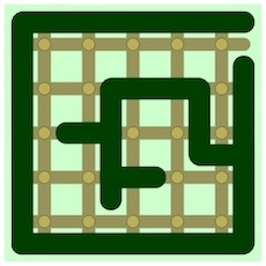


In this section, we consider a variation of the problem considered in the previous section.  Namely, given a maze, one should find a way to escape from it.  Notice that, in this case, the set of states forms a grid (as in the previous section) with a few points excluded, the initial state will be the one in the center of the maze $(0, 0)$, and the list of actions will encode the movements of the actions used in the previous section.  Since our goal is to escape the maze (that is, reach the state $(3, 2)$), we assign to each state a reward that is given as the distance from the state to the center of the maze.


In [ ]:
states = {(0, 0): 0,
          (1, 0): 1,
          (1, -1): 2,
          (2, -1): 3,
          (2, -2): 4,
          (1, -2): 3,
          (0, -2): 2,
          (-1, -2): 3,
          (-2, -2): 4,
          (-1, -1): 2,
          (-2, -1): 3,
          (-2, 0): 2,
          (-2, 1): 3,
          (-1, 1): 2,
          (-2, 2): 4,
          (-1, 2): 3,
          (0, 2): 2,
          (1, 2): 3,
          (2, 2): 4,
          (2, 1): 3,
          (3, 2): 5}

initial_state = (0, 0)

actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]


Next, define a function, `explore`, that creates 10 paths consisting of 50 steps through the maze.  It is similar to the exploration function defined in the previous section.  The main difference is that a neural network (`model`) will be used to bias the choice of the steps.  This means that, initially, the untrained neural network will choose the steps randomly.  But, as the the neural network is trained, it will choose steps that maximize the long-term reward of the path.


In [ ]:
def explore(model):
    paths = []

    for __ in range(10):

        path = []
        state = initial_state

        for _ in range(50):
            weights = model.predict(np.array(state).reshape(-1, 2), verbose=0)[0]
            action = random.choices(actions, weights)[0]
            next_state = tuple(np.array(state) + np.array(action))
            if next_state in states:
                path.append((state, action, next_state))
                state = next_state
            if reward(state) == 5:
                break

        if path:
            paths.append(path)

    return paths


The `monte carlo` function below is also very similar to the one used in the previous section to propagate the cummulative rewards through the states visited in the paths, starting from their final state.


In [ ]:
def monte_carlo(paths):
    for path in paths:

        cummulative_reward = states[path[-1][2]]

        for step in path[::-1]:
            state = step[0]
            cummulative_reward = (cummulative_reward + reward(state))/2
            states[state] = cummulative_reward

    return paths


Next, we define a function that will train the neural network.  Since this is the first time that we use a neural network in this notebook, this function has no analogue in the previous section.  

A neural network is a function that models another function.  The elements in the domains of these functions are called _features_ and the elements in their codomains are called _labels_.  (For more details, see the notebook [ML - neural networks](https://github.com/tiagormacedo/machine-learning/blob/main/ML%20-%20neural%20networks.ipynb).)  In our case, the features will be states and the labels will be actions.  Hence, to train a neural network to assign an action to a state, we will construct numpy-arrays containing the features (states) and labels (actions) from a given list of paths. Then, we fit (or adjust) the neural network (`model`).


In [ ]:
def train_model(paths):
    features = []
    labels = []

    for path in paths:
        for step in path:
            state = step[0]
            features.append(state)

            action = [0, 0, 0, 0]
            idx = actions.index(step[1])
            action[idx] += 1
            labels.append(action)

    features = np.array(features).reshape(-1, 2)
    labels = np.array(labels).reshape(-1, 4)

    model.fit(features, labels)
    return model


Now, it is time to construct the neural network that will be trained to determine the best action for each state. We begin by importing a few Python libraries that will be used to construct the neural network.


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


Then, we construct a fully-connected neural network with 2 hidden layers.  The input layer has dimension 2 (the coordinates of the state), the first hidden layer has dimension 16, the second hidden layer has dimension 8, and the output layer has dimension 4 (each one representing one possible action).  Notice that, in each hidden layer, we use the _ReLU_ activation function, and in the output layer we use a _softmax_ activation function, so the output represents a probability.  Also notice that we choose the loss function to be the _categorical cross entropy_ function and the Adam optimizer for the backpropagation process.

In [ ]:
###  NEURAL NETWORK  ###

model = Sequential()
model.add(Dense(16, input_shape=(2,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.05))


The last step is to put everything together.  First, the agent will explore the environment, then we apply a Monte Carlo to adjust the rewards of the visited states, next we choose the 2 best paths to train the neural network, and finally, we train the neural network.  When these steps are repeated 50 times, this process takes around 30 minutes, and the resulting neural network is able to correctly find a path to escape the maze.


In [ ]:
for t in range(50):
    if t % 10 == 0:
        print(t)
    paths = explore(model)
    paths = monte_carlo(paths)
    best_paths = sorted(paths, key=lambda path: max([states[step[2]] for step in path]), reverse=True)[:2]
    model = train_model(best_paths)


In [ ]:
path = []
state = initial_state

for _ in range(100):
    weights = model.predict(np.array(state).reshape(-1, 2), verbose=0)[0]
    action = random.choices(actions, weights)[0]
    next_state = tuple(np.array(state) + np.array(action))
    if next_state in states:
        path.append((state, action, next_state))
        state = next_state

path


[((0, 0), (1, 0), (1, 0)),
 ((1, 0), (-1, 0), (0, 0)),
 ((0, 0), (1, 0), (1, 0)),
 ((1, 0), (-1, 0), (0, 0)),
 ((0, 0), (1, 0), (1, 0)),
 ((1, 0), (0, -1), (1, -1)),
 ((1, -1), (0, -1), (1, -2)),
 ((1, -2), (-1, 0), (0, -2)),
 ((0, -2), (-1, 0), (-1, -2)),
 ((-1, -2), (-1, 0), (-2, -2)),
 ((-2, -2), (0, 1), (-2, -1)),
 ((-2, -1), (0, 1), (-2, 0)),
 ((-2, 0), (0, 1), (-2, 1)),
 ((-2, 1), (0, 1), (-2, 2)),
 ((-2, 2), (1, 0), (-1, 2)),
 ((-1, 2), (1, 0), (0, 2)),
 ((0, 2), (1, 0), (1, 2)),
 ((1, 2), (1, 0), (2, 2)),
 ((2, 2), (1, 0), (3, 2))]

# 4. A fancy Markov Decision Process

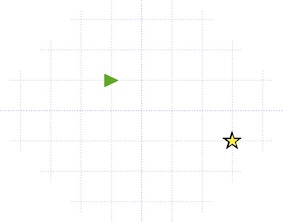


In this last section, we merge the methods developed above to show a method that can explore an unknown environment, estimate a value for each action, and then return a policy that guides the agent toward a goal. The environment created in this section is a grid similar to the ones used in the previous sections. But in this case, the agent only knows the available actions, the starting state, and the main goal. For simplicity, we will also assume that the agent's actions are deterministic.

We begin by setting up the set of actions that the agent can take, its initial state and a random goal.


In [ ]:
ACTIONS = {"left", "up", "right", "down"}
INITIAL_STATE = (0, 0)
GOAL = (random.randint(0, 5), random.randint(0, 5))


Now, we will write a loop that performs the exploration of the environment by the agent.  Notice that we start with a set of states that contains only the initial state.  While the agent explores the environment, the set of states will be populated with information about the environment.  In particular, for each state, we will record the reward of each one of the actions.


In [ ]:
# Fix the notation for the initial state
x, y = INITIAL_STATE

# Initialize the dictionary of states with the initial state and its rewards
states = {(x, y): {"left": 5 if (x, y-1) == GOAL else -1,
                   "up": 5 if (x-1, y) == GOAL else -1,
                   "right": 5 if (x, y+1) == GOAL else -1,
                   "down": 5 if (x+1, y) == GOAL else -1}}

# Fix three parameters: the number of exploratory walks, the length of each
# one of these exploratory walks, and the threshold for random actions
N_WALKS = 10
WALK_LENGTH = 10
EPSILON = 0.5

for _ in range(N_WALKS):

    # Start this walk at a random state
    x, y = random.choice([s for s in states])

    for __ in range(WALK_LENGTH):
        # Choose an action
        if random.uniform(0, 1) < EPSILON:
            action = random.choice(tuple(ACTIONS))
        else:
            action = max(states[(x, y)], key=states[(x, y)].get)

        # Change the state depending on which action was chosen
        if action == "left":
            y -= 1
        elif action == "right":
            y += 1
        elif action == "up":
            x -= 1
        elif action == "down":
            x += 1

        # If the current state has not been visited yet, gather its reward
        # information and feed it into the dictionary of states
        if (x, y) not in states:
            states[(x, y)] = {"left": 5 if (x, y-1) == GOAL else -1,
                              "up": 5 if (x-1, y) == GOAL else -1,
                              "right": 5 if (x, y+1) == GOAL else -1,
                              "down": 5 if (x+1, y) == GOAL else -1}

        # If the current state is the goal, stop this exploratory walk
        if (x, y) == GOAL:
            break


Next, we implement a _Monte Carlo_ process to adjust the rewards of the actions according to their role in a guided walk through the environment.  This method is known as _Q-learning_.


In [ ]:
# Fix a few parameters
N_EXPLORATIONS = 10
MAX_STEPS = 10
EPSILON = 0.25
DISCOUNT_RATE = 0.9
LEARNING_RATE = 0.1

for _ in range(N_EXPLORATIONS):
    # Choose a random state for the agent to start
    x, y = random.choice([s for s in states])

    # Walk through the environment collecting state and action information
    # of each step into a list
    exploration = []

    for __ in range(MAX_STEPS):
        # Choose an action
        if (random.uniform(0, 1) < EPSILON) or ((x, y) not in states):
            action = random.choice(tuple(ACTIONS))
        else:
            action = max(states[(x, y)], key=states[(x, y)].get)

        # Feed this information into the exploration list
        exploration.append({'state': (x, y), 'action': action})

        # Take the step relative to the chosen action
        if action == "left":
            y -= 1
        elif action == "right":
            y += 1
        elif action == "up":
            x -= 1
        elif action == "down":
            x += 1

        # If the current state has not been visited yet, gather its reward
        # information and feed it into the dictionary of states
        if (x, y) not in states:
            states[(x, y)] = {"left": 5 if (x, y-1) == GOAL else -1,
                              "up": 5 if (x-1, y) == GOAL else -1,
                              "right": 5 if (x, y+1) == GOAL else -1,
                              "down": 5 if (x+1, y) == GOAL else -1}

        # If the current state is the goal, finish this walk
        if (x, y) == GOAL:
            break

    # Adjust the rewards of the actions taken in this walk (Q-learning)
    cumulative_reward = 0

    for step in exploration[::-1]:
        state = step['state']
        action = step['action']
        cumulative_reward = max(states[state].values()) + DISCOUNT_RATE * cumulative_reward
        states[state][action] = (1 - LEARNING_RATE) * states[state][action] + LEARNING_RATE * cumulative_reward


Finally, we will display a matrix that represents the resulting policy in the neighborhood of the goal.


In [ ]:
###  Display the policy as a matrix  ###

states[GOAL] = {"left": -1, "up": -1, "right": -1, "down": -1}

x_min = min([row  for row, column in states])
x_max = max([row  for row, column in states])
height = x_max - x_min + 1

y_min = min([column  for row, column in states])
y_max = max([column  for row, column in states])
width = y_max - y_min + 1

matrix = [[" "  for j in range(width)]  for i in range(height)]

for x, y in states:
    best_action = max(states[(x, y)], key=states[(x, y)].get)

    row = x - x_min
    column = y - y_min

    if best_action == "right":
        matrix[row][column] = '>'
    elif best_action == "left":
        matrix[row][column] = '<'
    elif best_action == "up":
        matrix[row][column] = '^'
    elif best_action == "down":
        matrix[row][column] = 'v'

x_goal, y_goal = GOAL
matrix[x_goal-x_min][y_goal-y_min] = '*'


print(np.array(matrix)[x_goal-x_min-5:x_goal-x_min+5, y_goal-y_min-5:y_goal-y_min+5])


[['<' ' ' ' ' ' ' ' ' ' ']
 ['<' '<' '<' ' ' ' ' ' ']
 ['<' '<' ' ' ' ' ' ' ' ']
 [' ' '<' '<' ' ' ' ' ' ']
 ['<' '<' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' '*']]


Notice that the policy above is not good at finding a path towards the goal.  In fact, one must run the exploration and Monte Carlo loops a few times before the resulting policy shows signs that the agent is learning to walk towards the goal.  We will implement this iterative process below.


In [ ]:
# Fix the notation for the initial state
x, y = INITIAL_STATE

# Initialize the dictionary of states with the initial state and its rewards
states = {(x, y): {"left": 5 if (x, y-1) == GOAL else -1,
                   "up": 5 if (x-1, y) == GOAL else -1,
                   "right": 5 if (x, y+1) == GOAL else -1,
                   "down": 5 if (x+1, y) == GOAL else -1}}


for _ in range(1000):
    ###  EXPLORATION PART  ###

    # Fix three parameters: the number of exploratory walks, the length of each
    # one of these exploratory walks, and the threshold for random actions
    N_WALKS = 10
    WALK_LENGTH = 10
    EPSILON = 0.5

    for __ in range(N_WALKS):

        # Start this walk at a random state
        x, y = random.choice([s for s in states])

        for ___ in range(WALK_LENGTH):
            # Choose an action
            if random.uniform(0, 1) < EPSILON:
                action = random.choice(tuple(ACTIONS))
            else:
                action = max(states[(x, y)], key=states[(x, y)].get)

            # Change the state depending on which action was chosen
            if action == "left":
                y -= 1
            elif action == "right":
                y += 1
            elif action == "up":
                x -= 1
            elif action == "down":
                x += 1

            # If the current state has not been visited yet, gather its reward
            # information and feed it into the dictionary of states
            if (x, y) not in states:
                states[(x, y)] = {"left": 5 if (x, y-1) == GOAL else -1,
                                "up": 5 if (x-1, y) == GOAL else -1,
                                "right": 5 if (x, y+1) == GOAL else -1,
                                "down": 5 if (x+1, y) == GOAL else -1}

            # If the current state is the goal, stop this exploratory walk
            if (x, y) == GOAL:
                break


    ###  MONTE CARLO PART  ###

    # Fix a few parameters
    N_EXPLORATIONS = 10
    MAX_STEPS = 10
    EPSILON = 0.25
    DISCOUNT_RATE = 0.9
    LEARNING_RATE = 0.1

    for __ in range(N_EXPLORATIONS):
        # Choose a random state for the agent to start
        x, y = random.choice([s for s in states])

        # Walk through the environment collecting state and action information
        # of each step into a list
        exploration = []

        for ___ in range(MAX_STEPS):
            # Choose an action
            if (random.uniform(0, 1) < EPSILON) or ((x, y) not in states):
                action = random.choice(tuple(ACTIONS))
            else:
                action = max(states[(x, y)], key=states[(x, y)].get)

            # Feed this information into the exploration list
            exploration.append({'state': (x, y), 'action': action})

            # Take the step relative to the chosen action
            if action == "left":
                y -= 1
            elif action == "right":
                y += 1
            elif action == "up":
                x -= 1
            elif action == "down":
                x += 1

            # If the current state has not been visited yet, gather its reward
            # information and feed it into the dictionary of states
            if (x, y) not in states:
                states[(x, y)] = {"left": 5 if (x, y-1) == GOAL else -1,
                                "up": 5 if (x-1, y) == GOAL else -1,
                                "right": 5 if (x, y+1) == GOAL else -1,
                                "down": 5 if (x+1, y) == GOAL else -1}

            # If the current state is the goal, finish this walk
            if (x, y) == GOAL:
                break

        # Adjust the rewards of the actions taken in this walk (Q-learning)
        cumulative_reward = 0

        for step in exploration[::-1]:
            state = step['state']
            action = step['action']
            cumulative_reward = max(states[state].values()) + DISCOUNT_RATE * cumulative_reward
            states[state][action] = (1 - LEARNING_RATE) * states[state][action] + LEARNING_RATE * cumulative_reward


# Display the policy as a matrix

states[GOAL] = {"left": -1, "up": -1, "right": -1, "down": -1}

x_min = min([row  for row, column in states])
x_max = max([row  for row, column in states])
height = x_max - x_min + 1

y_min = min([column  for row, column in states])
y_max = max([column  for row, column in states])
width = y_max - y_min + 1

matrix = [[" "  for j in range(width)]  for i in range(height)]

for x, y in states:
    best_action = max(states[(x, y)], key=states[(x, y)].get)

    row = x - x_min
    column = y - y_min

    if best_action == "right":
        matrix[row][column] = '>'
    elif best_action == "left":
        matrix[row][column] = '<'
    elif best_action == "up":
        matrix[row][column] = '^'
    elif best_action == "down":
        matrix[row][column] = 'v'

x_goal, y_goal = GOAL
matrix[x_goal-x_min][y_goal-y_min] = '*'

print("Resulting policy:")
print(np.array(matrix)[x_goal-x_min-5:x_goal-x_min+5, y_goal-y_min-5:y_goal-y_min+5])


Resulting policy:
[['<' '<' '<' '<']
 ['<' '<' '<' '<']
 ['<' '*' '<' '<']
 ['<' '<' '<' '<']]


# References:

* Geron, _Hands-on machine learning with Scikit-Learn and TensorFlow_.

* Jaffry, [_Grid World Environment_](http://github.com/SRJaffry/GridWorld_Environment/blob/master/GridWorld_Env%20Final.ipynb).

*  Kansal and Martin, [_Reinforcement Q-Learning from Scratch in Python with OpenAI Gym_](http://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/).

* Martínez, [_Reinforcement learning (RL) 101 with Python_](http://medium.com/towards-data-science/reinforcement-learning-rl-101-with-python-e1aa0d37d43b).

* Sutton and Barto, _Reinforcement learning: An introduction_.
